## Software defined radio

the software defined radio converts a selected high frequency signal to frequencies around 0Hz, wich can be sampled by an ADC. This is done by means of heterodyne mixing with a local oszillator of the same frequency and filtering the high frequency result. By this procedure amplitude, phase differences frequency differences are preserved (if they are on a much larger time scale than the carrier frequency) and can be analyzed by software. If the heterodyne mixing is done additionaly with a $\pi/2$ shifted frequency, the I/Q (in phase/quadrature) data is directly generated.<br>
I'm using a simple RTL2832U R820T2 usb stick for 20€ to do so.

### heterodyne mixing

\begin{align}
2 \sin(\varphi) \sin(\theta) = \cos(\varphi-\theta) - \cos(\varphi+\theta) \\
2 \cos(\varphi) \cos(\theta) = \cos(\varphi-\theta) + \cos(\varphi+\theta)
\end{align}

# Radio modulation

## simple amplitude,phase,frequency modulation

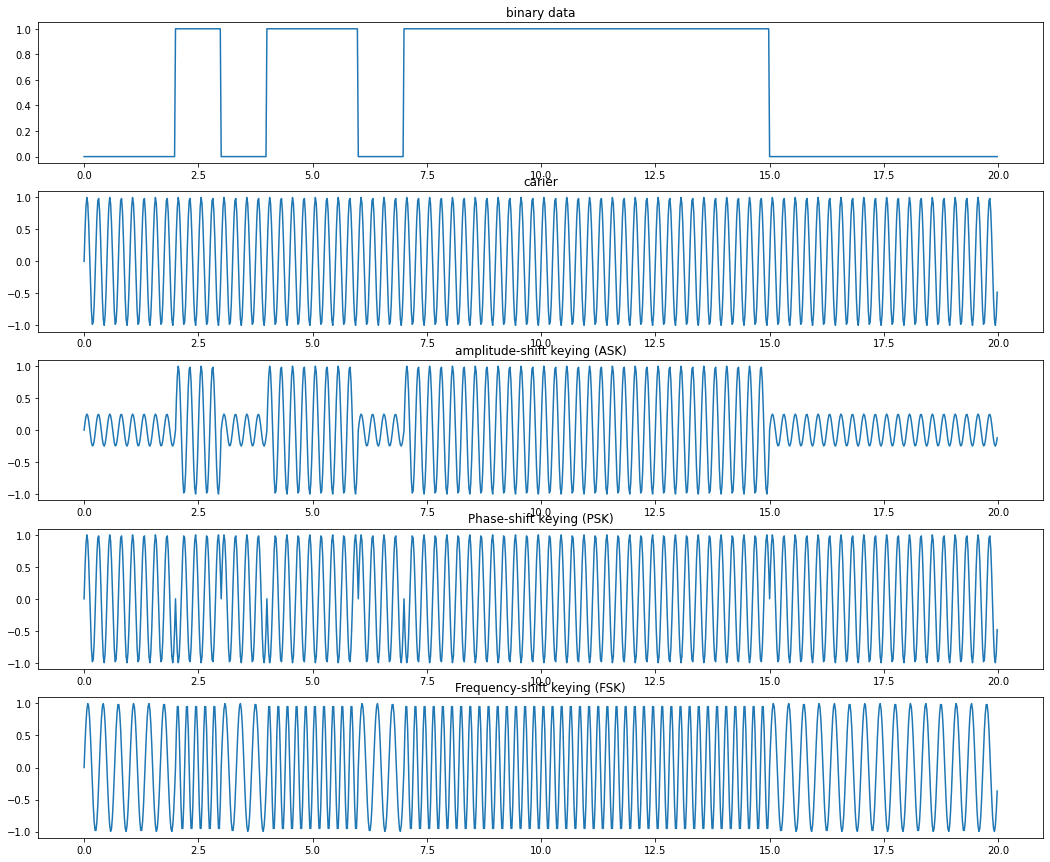

In [210]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

global pi,i
pi =np.pi
i = np.complex(0,1)

T = 20 #time range
N = 20 #data symbols
n = 1000 #data samples
dT = T/n #time step between samples
numN = n/N #samples per symbol
t = np.arange(0,T,dT)

data = np.zeros(n)
d = np.round(np.random.rand(N))
for ii in range(N):
    if d[ii]==1:
        data[int(ii*numN):int((ii+1)*numN)] = 1

f_c = 4
carrier = np.sin(2*pi*f_c*t)
ask_signal = carrier * (0.75*data+0.25) #amplitude modulation
psk_signal = np.sin(2*pi*f_c*t + pi*data) #phase modulation
fsk_signal = np.sin(2*pi*(f_c+2*(data-0.5))*t) #frequency modulation

fig = plt.figure(figsize=(18,15))

plt.subplot(5,1,1)
plt.title('binary data')
plt.plot(t,data)

plt.subplot(5,1,2)
plt.title('carier')
plt.plot(t,carrier)

plt.subplot(5,1,3)
plt.title('amplitude-shift keying (ASK)')
plt.plot(t,ask_signal)

plt.subplot(5,1,4)
plt.title('Phase-shift keying (PSK)')
plt.plot(t,psk_signal)

plt.subplot(5,1,5)
plt.title('Frequency-shift keying (FSK)')
plt.plot(t,fsk_signal)

plt.show()

### Amplitude
Amplitude shift keying (ASK): normal/binary(2;BASK) <br>
modulates amplitude, phase stays the same.<br>
the Information is conveyed on the real axis with changing vector length.<br>
demodulation:<br>
- multiplication with carrier (heterodyne mixing) $f_c \rightarrow 0,2f_c$ & low pass filter high frequency
- peak detection


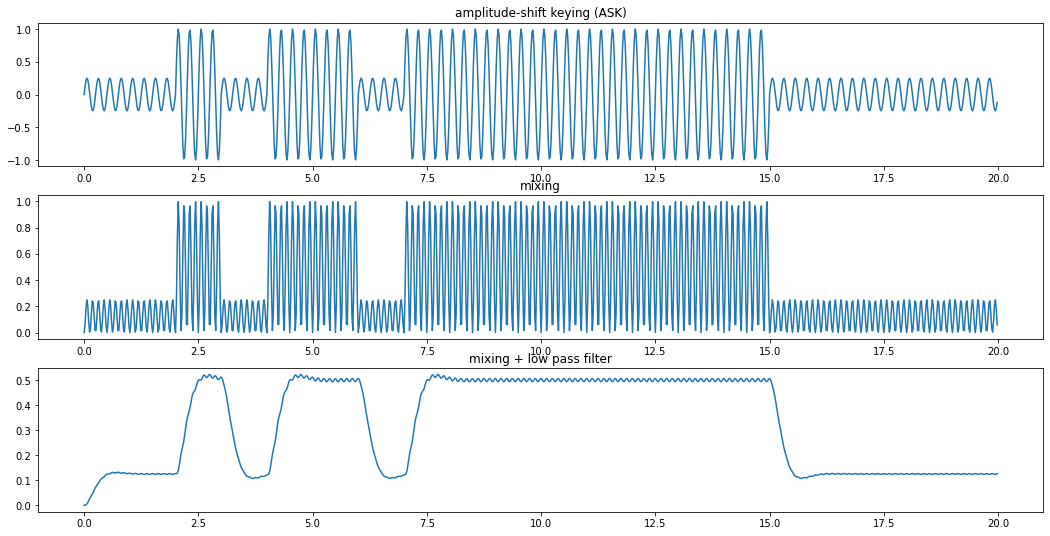

In [211]:
mixed = ask_signal * carrier
sos = signal.butter(2, 1, 'low', fs=1/dT, output='sos') #generate filter
filtered = signal.sosfilt(sos, mixed)

fig = plt.figure(figsize=(18,9))

plt.subplot(3,1,1)
plt.title('amplitude-shift keying (ASK)')
plt.plot(t,ask_signal)

plt.subplot(3,1,2)
plt.title('mixing')
plt.plot(t,mixed)

plt.subplot(3,1,3)
plt.title('mixing + low pass filter')
plt.plot(t,filtered)

plt.show()

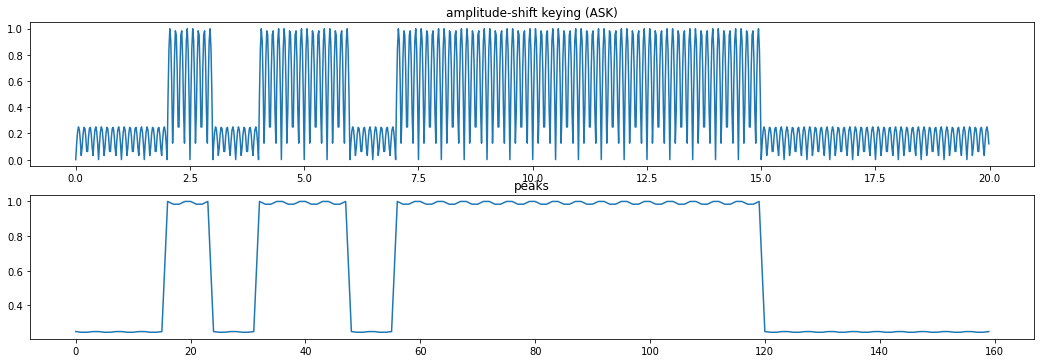

In [212]:
ask_signal = abs(ask_signal)
peak_ind, _ = signal.find_peaks(ask_signal)
peaks = ask_signal[peak_ind]

fig = plt.figure(figsize=(18,9))

plt.subplot(3,1,1)
plt.title('amplitude-shift keying (ASK)')
plt.plot(t,ask_signal)

plt.subplot(3,1,2)
plt.title('peaks')
plt.plot(peaks)

plt.show()

### Phase
Phase shift keying (PSK): normal/binary(2;BPSK)/quadratue(4;QPSK)/differential(relative phase shifts;DQPSK)<br>
modulates the phase shift, amplitude stays the same.<br>
the information is conveyed on a unit circle in complex space.<br>
at the moment of the phase shift the frequency is infinite.<br>
demodulation:<br>
- exact timing to separate individual bit signals -> multiplication with carrier (heterodyne mixing) $2\sin(f_c+\varphi_1)\sin(f_c+\varphi_2) = \cos(\varphi_1-\varphi_2)-\cos(2f_c+\varphi_1+\varphi_2)$ -> if $\cos(\varphi_1-\varphi_2)$ produces a positive DC offset for a phase difference of $0^\circ$ and a negative DC offset for a phase difference of $180^\circ$


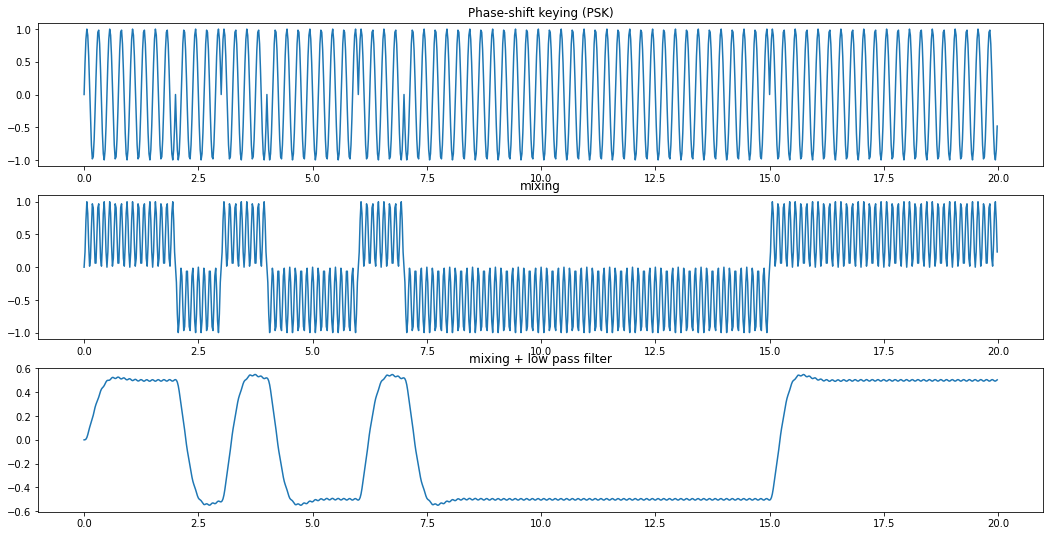

In [213]:
mixed = psk_signal * carrier
sos = signal.butter(2, 1, 'low', fs=1/dT, output='sos') #generate filter
filtered = signal.sosfilt(sos, mixed)

fig = plt.figure(figsize=(18,9))

plt.subplot(3,1,1)
plt.title('Phase-shift keying (PSK)')
plt.plot(t,psk_signal)

plt.subplot(3,1,2)
plt.title('mixing')
plt.plot(t,mixed)

plt.subplot(3,1,3)
plt.title('mixing + low pass filter')
plt.plot(t,filtered)


plt.show()

### Frequency
FSK (Frequency Shift keying)<br>
modulates frequency, amplitude stays the same.<br>
the information is conveyed by constantly rotating on the unit circle.<br>
equal to phase change linear in time,where the direction of the phase change conveys the information.
demodulation:<br>
- high pass filter -> amplitude demodulation
- phase locked loop (PLL) corrects local oscillation to match input wave form. Amount of frequency correction is equal to the original signal.
- iq (complex data) -arctan-> angle -difference-> change of angle = frequency

#### MSK

MSK (Minimum shift keying)<br>
It's a variant of FSK with a continuous waveform, since the frequency difference is chosen to be half the bit rate.<br>
This can be illustrated by the argument of sine:
\begin{align}
2 \pi \big( f_1 \Delta t - f_2 \Delta t \big) = \pi \\
\Delta f = \frac{1}{2 \Delta t}
\end{align}

#### GMSK
Data is filtered by a gaussian lowpass filter before it's modulated with MSK. This reduces the bandwidth of the spectrum further. used for GSM !

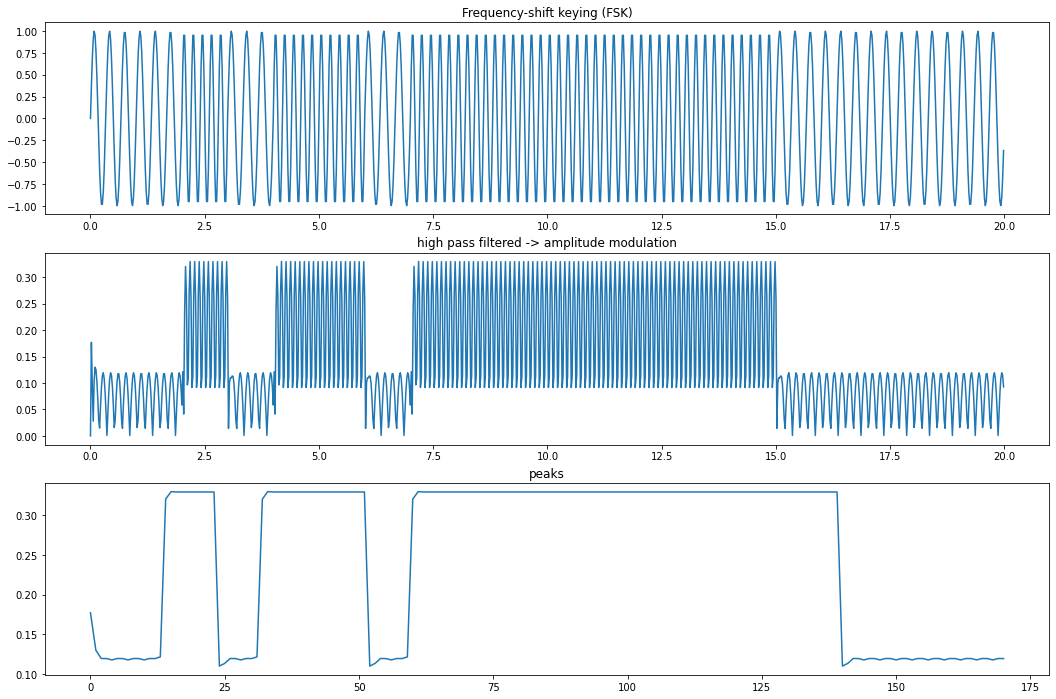

In [214]:
sos = signal.butter(2, 2*f_c, 'high', fs=1/dT, output='sos') #generate filter
filtered = signal.sosfilt(sos, fsk_signal)
filtered = abs(filtered)
peak_ind, _ = signal.find_peaks(filtered)
peaks = filtered[peak_ind]

fig = plt.figure(figsize=(18,12))

plt.subplot(3,1,1)
plt.title('Frequency-shift keying (FSK)')
plt.plot(t,fsk_signal)

plt.subplot(3,1,2)
plt.title('high pass filtered -> amplitude modulation')
plt.plot(t,filtered)

plt.subplot(3,1,3)
plt.title('peaks')
plt.plot(peaks)

plt.show()

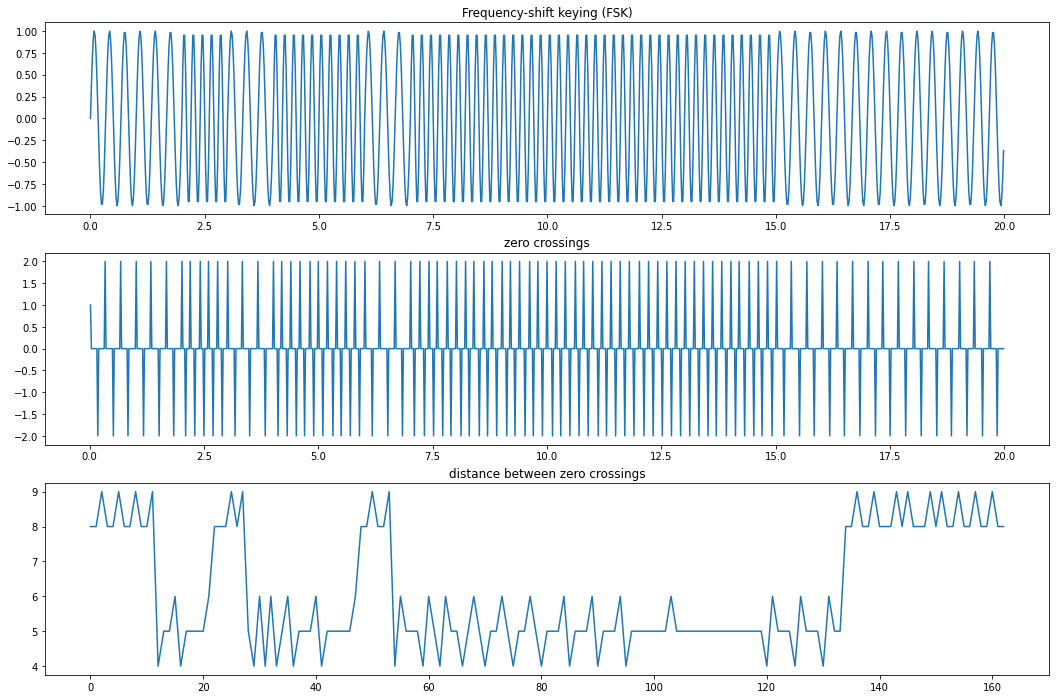

In [215]:
zero_crossings = np.diff(np.sign( fsk_signal ))
zero_distance = np.diff(np.where(zero_crossings))[0]

fig = plt.figure(figsize=(18,12))

plt.subplot(3,1,1)
plt.title('Frequency-shift keying (FSK)')
plt.plot(t,fsk_signal)

plt.subplot(3,1,2)
plt.title('zero crossings')
plt.plot(t[1:],zero_crossings)

plt.subplot(3,1,3)
plt.title('distance between zero crossings')
plt.plot(zero_distance)

plt.show()

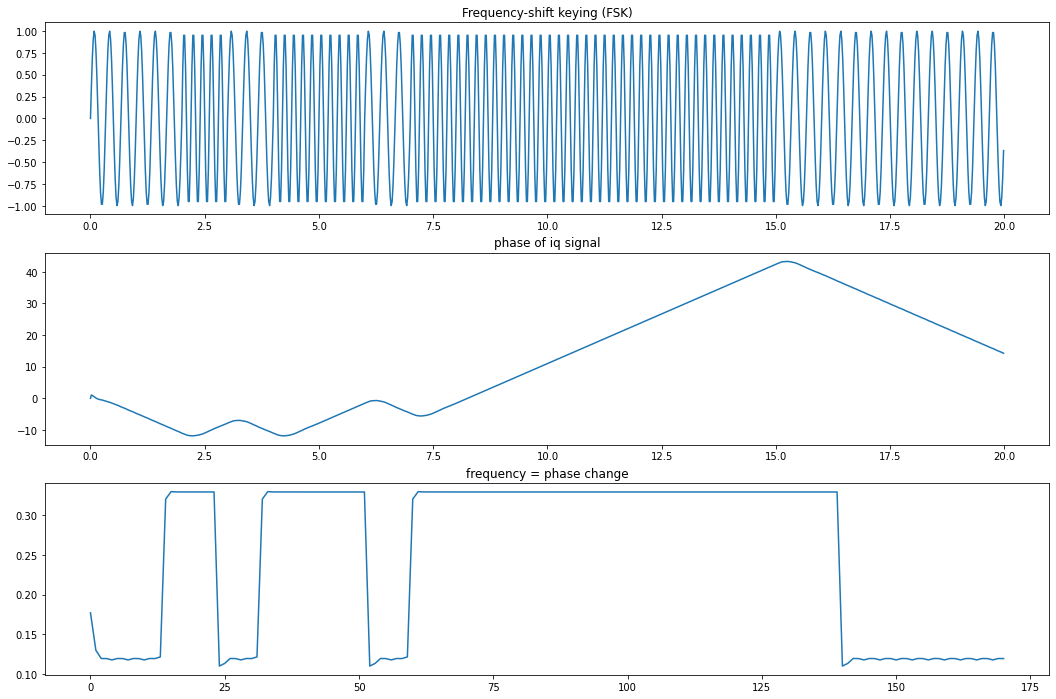

In [226]:
in_phase = np.sin(2*pi*f_c*t)*fsk_signal
quadrature = np.sin(2*pi*f_c*t+pi/2)*fsk_signal
### low pass filter not needed, here it is nonetheless
sos = signal.butter(2, 1, 'low', fs=1/dT, output='sos') #generate filter
in_phase = signal.sosfilt(sos, in_phase)
quadrature = signal.sosfilt(sos, quadrature)
###
complx = in_phase + i*quadrature
phase = np.unwrap(np.angle(complx))
freq = np.diff(phase)

fig = plt.figure(figsize=(18,12))

plt.subplot(3,1,1)
plt.title('Frequency-shift keying (FSK)')
plt.plot(t,fsk_signal)

plt.subplot(3,1,2)
plt.title('phase of iq signal')
plt.plot(t,phase)

plt.subplot(3,1,3)
plt.title('frequency = phase change')
plt.plot(peaks)


plt.show()

### Theory for QAM (with in Phase [I] & Quadrature [Q] components)

QAM (Quadrature amplitude modulation) signal is composed of two (orthogonal) carier sine waves with $\pi/2$ lag:
\begin{align}
s(t) &= I(t) \sin(2 \pi f_c t) + Q(t) \sin(2 \pi f_c t + \pi/2) \\
&= e^{i 2 \pi f_c t} \frac{I(t)+iQ(t)}{2} \\
&= c(t) \sin(i 2 \pi f_c t + \varphi(t))
\end{align}

Information is transmitted by $I(t)$ and $Q(t)$ each with n-bins. This is equal to points on a grid in complex space, wich results in n^2 bits per symbol.

The fourier transform returns the signal: 
\begin{align}
\mathcal{F} \big\{ s(t) \big\} &= \frac{\hat{I}(f-f_c)+i\hat{Q}(f-f_c)}{2}
\end{align}

alternatively the signal can be demodulated by multiplying with the same (orthogonal) sine waves. unfortunately a residue phase shift $\varphi_0$ cannot be determined prior:

\begin{align}
\sin(2 \pi f_c t + \varphi_0) \cdot s(t) &= I(t) \big( \sin(2 \pi f_c t + \varphi_0) \sin(2 \pi f_c t) \big) + Q(t) \big( \sin(2 \pi f_c t + \varphi_0) \sin(2 \pi f_c t + \pi/2) \big) \\
&= I(t) \big( \cos(\varphi_0) - \cos(2 \pi 2 f_c t + \varphi_0) \big) + Q(t) \big( \cos(\varphi_0 - \pi/2) - \cos(2 \pi 2 f_c t + \varphi_0 + \pi/2) \big) \\
\text{bandpass:} \quad &= I(t) \cos(\varphi_0) + Q(t) \cos(\varphi_0 - \pi/2) \\
\varphi_0=0 \quad &\approx I(t)
\end{align}

\begin{align}
\sin(2 \pi f_c t + \pi/2 + \varphi_0) \cdot s(t) &= I(t) \big( \sin(2 \pi f_c t + \pi/2 + \varphi_0) \sin(2 \pi f_c t) \big) + Q(t) \big( \sin(2 \pi f_c t + \pi/2 + \varphi_0) \sin(2 \pi f_c t + \pi/2) \big) \\
&= I(t) \big( \cos(\pi/2 + \varphi_0) - \cos(2 \pi 2 f_c t + \pi/2 + \varphi_0) \big) + Q(t) \big( \cos(\varphi_0) - \cos(2 \pi 2 f_c t + \pi + \varphi_0) \big) \\
\text{bandpass:} \quad &= I(t) \cos(\pi/2 + \varphi_0) + Q(t) \cos(\varphi_0) \\
\varphi_0=0 \quad &\approx Q(t)
\end{align}


## FM demodulation
iq data (complex data) -arctan-> angle -difference-> change of angle = frequency

\begin{align}
f &= \frac{d}{dt} \arctan(Q/I) \\
&= \frac{1}{1+(Q/I)^2} \frac{d (Q/I)}{dt} \\
&= \frac{1}{1+(Q/I)^2} \frac{I\frac{d Q}{dt} - Q\frac{d I}{dt}}{I^2} \\
&= \frac{I\frac{d Q}{dt} - Q\frac{d I}{dt}}{I^2 + Q^2} \\
&\approx I\frac{d Q}{dt} - Q\frac{d I}{dt} \\
\end{align}


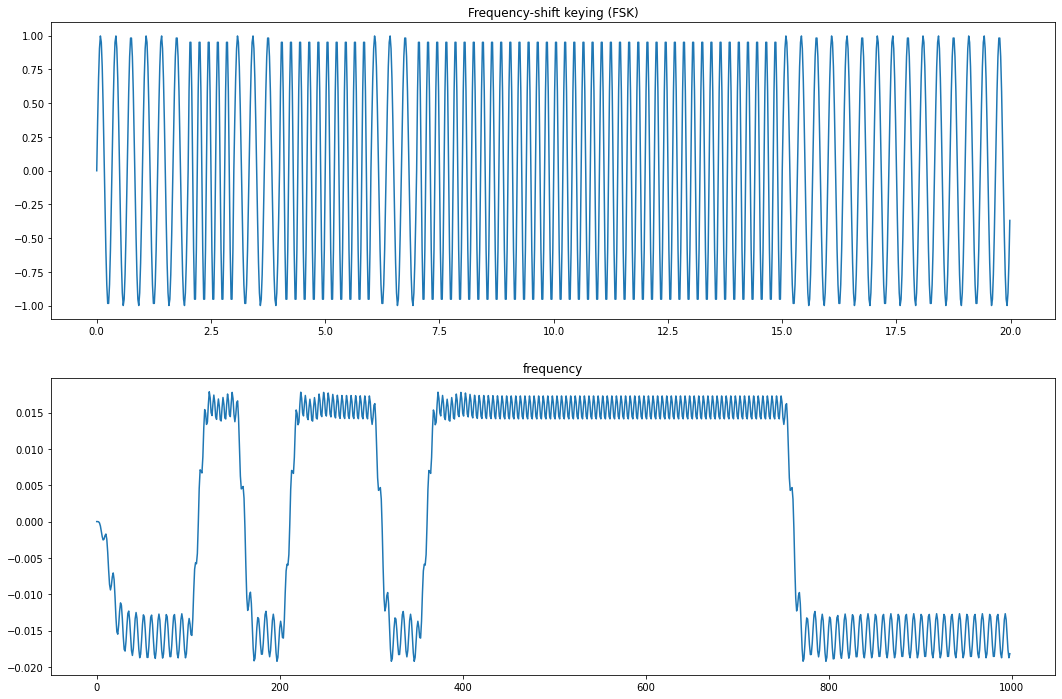

In [228]:
in_phase = np.sin(2*pi*f_c*t)*fsk_signal
quadrature = np.sin(2*pi*f_c*t+pi/2)*fsk_signal
### low pass filter not needed, here it is nonetheless
sos = signal.butter(2, 1, 'low', fs=1/dT, output='sos') #generate filter
in_phase = signal.sosfilt(sos, in_phase)
quadrature = signal.sosfilt(sos, quadrature)
###
freq = in_phase[1:]*np.diff(quadrature) - quadrature[1:]*np.diff(in_phase)

fig = plt.figure(figsize=(18,12))

plt.subplot(2,1,1)
plt.title('Frequency-shift keying (FSK)')
plt.plot(t,fsk_signal)

plt.subplot(2,1,2)
plt.title('frequency')
plt.plot(freq)

plt.show()